# 1. Regressive Tennis T-Test

Use a linear regression and statsmodels to run a t-test on whether Federer scores more points than his opponents in the `tennis.csv` dataset.

Give a one-paragraph interpretation of the coefficient, and the meaning of the p-value. 

Also answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?

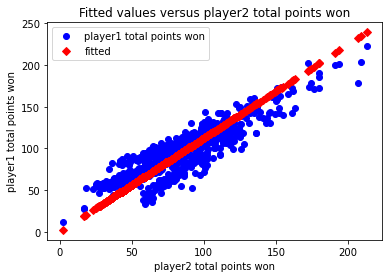

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     player1 total points won   R-squared (uncentered):                   0.969
Model:                                  OLS   Adj. R-squared (uncentered):              0.969
Method:                       Least Squares   F-statistic:                          2.837e+04
Date:                      Wed, 20 Jan 2021   Prob (F-statistic):                        0.00
Time:                              11:43:54   Log-Likelihood:                         -4310.3
No. Observations:                      1027   AIC:                                      8623.
Df Residuals:                          1026   BIC:                                      8628.
Df Model:                                 1                                                  
Covariance Type:                        HC2                                                  
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
player2 total points won     1.1242      0.007    168.435      0.000       1.111       1.137
==============================================================================
Omnibus:                       72.672   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.996
Skew:                          -0.709   Prob(JB):                     1.29e-19
Kurtosis:                       3.147   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC2)
"""

In [53]:
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.datasets import load_boston
import pandas as pd
import io
import numpy as np
import seaborn as sns
import statsmodels.api as sm

data_url = 'data/tennis.csv'
dataframe = pd.read_csv(data_url)
df = dataframe
X = df[['player2 total points won']].dropna()
# X = sm.add_constant(X)
Y = df['player1 total points won'].dropna()
mod = sm.OLS(Y, X).fit(cov_type='HC2')
sm.graphics.plot_fit(mod, 0, vlines=False)
plt.show()
mod.summary()
# sns.regplot(df['player1 total points won'].dropna(),df['player2 total points won'].dropna())

In [44]:
"""
Question 1 Answers

For every point won by R. Federer the model predicts the opponent winning ~0.82 points.
This is consistent with the performance and career for R. Fed.
From the p-value (0.000), it is suggested that this model depicts a statistically significant relationship.

The nature of tennis also suggests that two equally matched opponents will necessarily
play a longer game, resulting in higher point totals for both players.

Constant Y/N, why?
Intuitively it feels appropriate to include a constant, as there is no possible 0-point games in tennis.
Visually (from the plot) it appears to improve the model accuracy in my estimation.

How does interpretation of coeff/p-val change with/without const?
With constant:
Coeff is ~0.82
P-val is 0.000

Without constant:
Coeff is ~1.12
P-val is 0.000
"""

'\nQuestion 1 Answers\n\nFor every point won by R. Federer the model predicts the opponent winning ~0.82 points.\nThis is consistent with the performance and career for R. Fed.\n\nConstant Y/N, why?\nHow does interpretation of coeff/p-val change with/without const?\n'

# 2. College admissions

Using the `college.csv` dataset, answer the following:

1. Is the relation between `Top10perc` and `Top25perc` best fit using a model with only one variable, or one variable and a polynomial of degree 2? Is a constant term useful? How would you select for the best of these model specifications?

2. Do private schools see more admissions overall? T-test this using a linear regression. Hint: use a binary explanatory variable for `Private`. Explain your model specification choices.


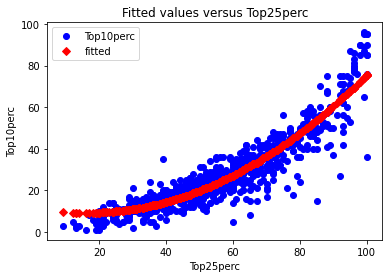

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Top10perc   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1487.
Date:                Wed, 20 Jan 2021   Prob (F-statistic):          8.02e-266
Time:                        11:40:08   Log-Likelihood:                -2578.5
No. Observations:                 777   AIC:                             5163.
Df Residuals:                     774   BIC:                             5177.
Df Model:                           2                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7490      1.862      6.310      0.000       8.100      15.398
Top25perc     -0.3124      0.079     -3.956      0.000      -0.467      -0.158
Top25perc2     0.0095      0.001     12.377      0.000       0.008       0.011
==============================================================================
Omnibus:                      184.094   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              954.340
Skew:                          -0.970   Prob(JB):                    5.86e-208
Kurtosis:                       8.071   Cond. No.                     3.05e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 3.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
# regression for top10perc/top25perc
data_url = r'data/college.csv'
dataframe = pd.read_csv(data_url)
df = dataframe
df['Top25perc2'] = df['Top25perc']**2

y = df['Top10perc']
x = df[['Top25perc','Top25perc2']]
x = sm.add_constant(x)
mod = sm.OLS(y,x).fit(cov_type='HC2')
sm.graphics.plot_fit(mod, 1, vlines=False)
plt.show()
mod.summary()

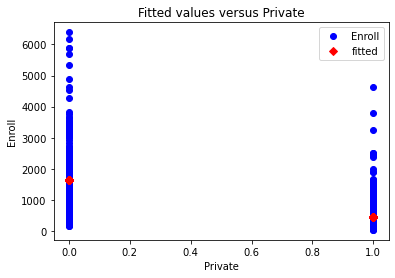

[ 1. -1.]
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0          2824.8002    174.359     16.201      0.000    2483.063    3166.537


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Enroll   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     177.9
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           1.09e-36
Time:                        11:14:09   Log-Likelihood:                -6261.0
No. Observations:                 777   AIC:                         1.253e+04
Df Residuals:                     775   BIC:                         1.254e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1640.8726     86.646     18.938      0.000    1471.049    1810.697
Private    -1183.9275     88.759    -13.339      0.000   -1357.891   -1009.964
==============================================================================
Omnibus:                      421.162   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3666.463
Skew:                           2.310   Prob(JB):                         0.00
Kurtosis:                      12.587   Cond. No.                         3.60
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [42]:
# regression for admission/private
data_url = r'data/college.csv'
dataframe = pd.read_csv(data_url)
df = dataframe
df['Private'] = pd.get_dummies(df['Private'], drop_first=True)
x = df['Private']
y = df[['Enroll']]
x = sm.add_constant(x)
mod = sm.OLS(y,x).fit(cov_type='HC2')
sm.graphics.plot_fit(mod, 1, vlines=False)
plt.show()
r = np.zeros_like(mod.params)
r[0] = 1
r[1] = -1
T_test = mod.t_test(r)
print(T_test)
mod.summary()

In [ ]:
"""
Question 2 Answers
1. Relationship appears to be best fit using a square polynomial feature, with a constant.
   My selection was based on comparison between results (and plots).
2. Honestly I'm not sure whether or not this model achieves the desired effect. 
   I chose enrollment as the simplest metric for admissions, treating private as the independent variable.
"""

# 3. Auto prediction

Using the `auto.csv` dataset, perform a simple linear regression with `mpg` as the response variable and horsepower as the predictor. Answer the following:

 i. Is there a relationship between the predictor and the response?
 
 ii. How strong is the relationship between the predictor and the response?
 
 iii. Is the relationship between the predictor and the response positive or negative?

 iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals ?

 v. Make a regression plot the response and the predictor.

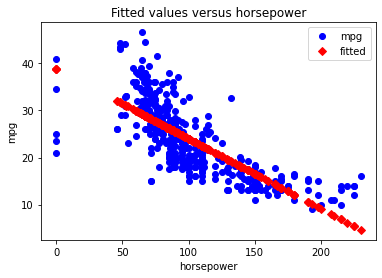

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     356.2
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           4.24e-57
Time:                        11:19:05   Log-Likelihood:                -1207.8
No. Observations:                 397   AIC:                             2420.
Df Residuals:                     395   BIC:                             2428.
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.8792      0.934     41.614      0.000      37.048      40.710
horsepower    -0.1489      0.008    -18.874      0.000      -0.164      -0.133
==============================================================================
Omnibus:                       12.157   Durbin-Watson:                   0.995
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.244
Skew:                           0.323   Prob(JB):                     0.000807
Kurtosis:                       3.667   Cond. No.                         306.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [43]:
auto = open('data/auto.csv', 'r')
read = auto.read()
read = read.split('\n')
# trim the useless line
read.pop(1)
# replace the ? in horsepower
for e in read:
    if '?' in e:
        ind = read.index(e)
        read[ind] = e.replace('?', '0')
read = '\n'.join(read)
inp = io.StringIO(read)
dataframe = pd.read_csv(inp, delim_whitespace=True)
df = dataframe

y = df['mpg']
x =  df['horsepower']
x = sm.add_constant(x)
mod = sm.OLS(y,x).fit(cov_type='HC2')
sm.graphics.plot_fit(mod, 1, vlines=False)
plt.show()
mod.summary()

In [ ]:
"""
Question 3 Answers
1. Yes
2. For every 1 horsepower, the model predicts a loss of ~0.15 mpg
3. Negative
4. ~24.3 +/- 0.016 (2*sd)
5. See above.

"""

# 4. Auto Multiple Regression

Perform a multiple linear regression with `mpg` as the response and all other variables except name in `auto` as the predictors. Comment on the output:

i. Is there a relationship between the predictors and the response?

ii. Which predictors appear to have a statistically significant relationship to the response?

iii. What does the coefficient for the year variable suggest?

iv. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers?

v. Is there heteroscedasticity in the fit?

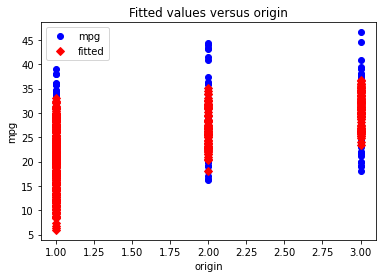

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     329.3
Date:                Wed, 20 Jan 2021   Prob (F-statistic):          1.05e-137
Time:                        16:46:50   Log-Likelihood:                -1038.4
No. Observations:                 397   AIC:                             2089.
Df Residuals:                     391   BIC:                             2113.
Df Model:                           5                                         
Covariance Type:                  HC2                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.2409      3.669     -4.700      0.000     -24.431     -10.051
displacement     0.0114      0.006      1.976      0.048    9.49e-05       0.023
horsepower      -0.0196      0.010     -1.920      0.055      -0.040       0.000
weight          -0.0064      0.001    -10.752      0.000      -0.008      -0.005
year             0.7558      0.048     15.668      0.000       0.661       0.850
origin           1.4014      0.270      5.183      0.000       0.871       1.931
==============================================================================
Omnibus:                       33.547   Durbin-Watson:                   1.288
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.701
Skew:                           0.542   Prob(JB):                     4.87e-13
Kurtosis:                       4.501   Cond. No.                     7.50e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 7.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [91]:
auto = open('data/auto.csv', 'r')
read = auto.read()
read = read.split('\n')
# trim the useless line
read.pop(1)
# replace the ? in horsepower
for e in read:
    if '?' in e:
        ind = read.index(e)
        read[ind] = e.replace('?', '0')
read = '\n'.join(read)
inp = io.StringIO(read)
dataframe = pd.read_csv(inp, delim_whitespace=True)
df = dataframe

y = df['mpg']
x = df.drop(['mpg', 'name', 'acceleration', 'cylinders'], 1)
x = sm.add_constant(x)
mod = sm.OLS(y,x).fit(cov_type='HC2')
sm.graphics.plot_fit(mod, 5, vlines=False)
plt.show()
mod.summary()
# x.dtypes
# x

In [ ]:
"""
Question 4 Answers
1. Yes
2. Year, Weight, Displacement, Origin
3. It suggests that production year is one of the most (if not the most) important predictor of mpg
4. Certain features (accel/cylinders) report p-values that suggest insignificance. Also origin seems odd.
5. Yes, particularly for acceleration.
"""

# 5. Car Seats

This question should be answered using the Carseats data set

1. Fit a multiple regression model to predict Sales using Price, Urban, and US.

2. Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

3. For which of the predictors can you reject the null hypothesis H0 : βj = 0?

4. On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

5. How well do the models in 1 and 4 fit the data? Explain which statistics show the difference.

6. Using the model from (e), obtain 95 % confidence intervals for the coefficient(s).

In [70]:
data_url = r'data/carseats.csv'
dataframe = pd.read_csv(data_url)
df = dataframe
df['US'] = pd.get_dummies(df['US'], drop_first=True)
df['Urban'] = pd.get_dummies(df['Urban'], drop_first=True)
y = df['Sales']
x1 = df[['US','Price', 'Urban']]
x1 = sm.add_constant(x1)
x2 = df[['US','Price']]
x2 = sm.add_constant(x2)
mod1 = sm.OLS(y,x1).fit(cov_type='HC2')
mod2 = sm.OLS(y,x2).fit(cov_type='HC2')
mod1.summary(),mod2.summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                  Sales   R-squared:                       0.239
 Model:                            OLS   Adj. R-squared:                  0.234
 Method:                 Least Squares   F-statistic:                     43.09
 Date:                Wed, 20 Jan 2021   Prob (F-statistic):           4.04e-24
 Time:                        14:03:51   Log-Likelihood:                -927.66
 No. Observations:                 400   AIC:                             1863.
 Df Residuals:                     396   BIC:                             1879.
 Df Model:                           3                                         
 Covariance Type:                  HC2                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ---------------------------------------------------------------------

In [ ]:
"""
Question 5 Answers
1. See above (mod1)
2. US: US = 1 results in ~20% increase in sales, compared to US = 0
   Price: For each increase in sales of 1, model predicts a decrease in price by a factor of ~0.05
   Urban:  Urb = 1 results in a decrease in sales by a factor of ~0.02, compared to Urb = 0
   
3. US & Price
4. See above (mod2)
5. We see small improvements in: AIC/BIC, Adj. R2, and a larger improvement in Cond. No.
6. Price: -0.065,-0.0443
   US:     0.716, 1.68
"""